In [1]:
import pandas as pd #pandas is built on numpy and makes data management easy
import numpy as np #a python computation necessity- much faster than using native python ints and lists
from scipy.integrate import odeint #scipy fortran wrapper for integration
import pylab
from src.batch_fitting_module import model_5infection,integrate,do_fitting
#this allows us to seemlessly swap to R from within our python notebook!
%load_ext rpy2.ipython

/home/spiridon/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Parameter Fitting of Viral Host Interactions

## The Model
The model we will be using will have 5 infection states, as outlinelined bellow:  

$$\frac{dS}{dt} = \mu S - \phi S V$$  
$$\frac{dI_1}{dt} = \phi S V - \frac{I_1}{\tau_1}$$  
$$\frac{dI_2}{dt} = \frac{I_1}{\tau_1} - \frac{I_2}{\tau_2}$$  
$$\frac{dI_3}{dt} = \frac{I_2}{\tau_2} - \frac{I_3}{\tau_3}$$  
$$\frac{dI_4}{dt} = \frac{I_3}{\tau_3} - \frac{I_4}{\tau_4}$$  
$$\frac{dI_5}{dt} = \frac{I_4}{\tau_4} - \lambda I_5 $$  
$$\frac{dV}{dt} = \beta \lambda I_5 - \phi S V $$  

| symbol  | Description   
|----|--------------------
| $$S$$  | Host Abundance             
| $$I_i$$ | Infection State
| $$\phi$$  | Transfer Affinity
| $$\tau_i$$  | Turnover of $I_i$
| $$\beta$$  | Burst Size
| $$\lambda$$  | Lysis Rate
| $$\mu$$  | Growth Rate

Our goal will be to find the parameter values for $\lambda$, $\phi$, all $\tau$, $\beta$ and $\mu$ 

In [2]:
# host sampling times
htimes =  np.r_[[0. , 0.2, 0.3, 0.5, 0.7, 0.9, 1. , 1.2, 1.3, 1.5, 1.7, 1.8, 2. ,
        2.2, 2.3, 2.5, 2.8, 3. ]]
# virus sampling times
vtimes = np.r_[[0. , 0.2, 0.3, 0.5, 0.7, 0.9, 0.9, 1. , 1.2, 1.3, 1.5, 1.7, 1.8,
        2. , 2.2, 2.3, 2.5, 2.8, 3. ]]
# host abundances
hms = np.r_[[5236900., 5768400., 5835000., 4846200., 4702100., 4283600.,
        3675000., 3466700., 3385700., 2143500., 1682400., 1179200.,
         971320.,  890380.,  957390.,  791980.,  734840.,  655160.]]
# virus abundances
vms = np.r_[[1.0981e+07, 1.2959e+07, 1.3273e+07, 1.7914e+07, 1.5899e+07,
        1.3881e+07, 1.5545e+07, 1.4527e+07, 1.2516e+07, 3.2464e+07,
        2.2129e+07, 3.2426e+07, 3.9063e+07, 6.5668e+07, 3.7031e+07,
        6.6297e+07, 9.1902e+07, 1.3446e+08, 1.6306e+08]]
# host uncertainty
hss = np.r_[[750750.0, 950680.0, 614550.0, 1024690.0, 1066300.0, 1319600.0,
        1890100.0, 1912950.0, 1837700.0, 1077450.0, 592060.0, 538460.0,
        422250.0, 232770.0, 105898.21, 232205.0, 200460.0, 306570.0]]
# virus uncertainty
vss = np.r_[[656690.0, 2987300.0, 3480600.0, 3981250.0, 4815700.0, 3985500.0,
        3491900.0, 5474350.0, 6314200.0, 22926000.0, 13453500.0,
        22594500.0, 2323200.0, 19773000.0, 5151000.0, 3986300.0, 1657250.0,
        11629500.0, 35377000.0]]
#Let's organize our data into a dataframe
virus = pd.DataFrame({'time':vtimes,'abundance':vms,'uncertainty':vss,'organism':'virus'})
host = pd.DataFrame({'time':htimes,'abundance':hms,'uncertainty':hss,'organism':'host'})
df = pd.concat([virus,host])
df = df.set_index(['organism']) #set the index, makes data access *much* easier
df

,time,abundance,uncertainty
organism,,,
virus,0.0,10981000.0,656690.00
virus,0.2,12959000.0,2987300.00
virus,0.3,13273000.0,3480600.00
virus,0.5,17914000.0,3981250.00
virus,0.7,15899000.0,4815700.00
virus,0.9,13881000.0,3985500.00
virus,0.9,15545000.0,3491900.00
virus,1.0,14527000.0,5474350.00
virus,1.2,12516000.0,6314200.00


In [3]:
parameters = {'host growth rate':1e-6,
              'transfer affinity':1e-6,
              'I1 turnover':0.2,
              'I2 turnover':0.2,
              'I3 turnover':0.2,
              'I4 turnover':0.2,
              'lysis rate':1.0,
              'burst size':50}
# time array and initial conditions
param_init = tuple([parameters[el] for el in parameters]) #we need a tuple of values
days = max(np.amax(df.loc['host']['time']),np.amax(df.loc['virus']['time'])) #find the maximum days from all times
times = np.arange(0, days, 900.0 / 86400.0)
#getting the initial value at time 0
inits = np.r_[[df.loc['host'].iloc[0]['abundance'],0,0,0,0,0,df.loc['virus'].iloc[0]['abundance']]]
h,v = integrate(df,model_5infection,inits,times,param_init)

[]

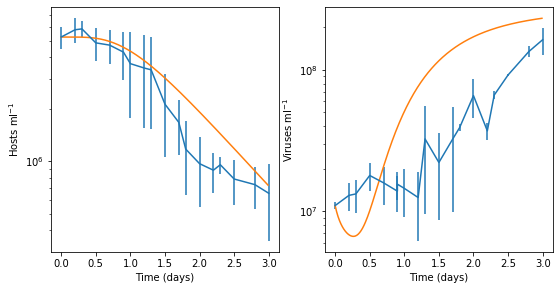

In [4]:
f,ax = pylab.subplots(1,2,figsize=[9,4.5])
ax[0].errorbar(df.loc['host']['time'],df.loc['host']['abundance'],yerr=df.loc['host']['uncertainty'])
ax[1].errorbar(df.loc['virus']['time'],df.loc['virus']['abundance'],yerr=df.loc['virus']['uncertainty'])
ax[0].plot(times,h,label='prior')
ax[1].plot(times,v)
ax[0].set_xlabel('Time (days)')
ax[1].set_xlabel('Time (days)')
ax[0].set_ylabel('Hosts ml$^{-1}$')
ax[1].set_ylabel('Viruses ml$^{-1}$')
ax[0].semilogy()
ax[1].semilogy()

# Initial Parameter Fit
Our inital parameter choice caused our fits to be less than idea. To optimize our fits, we will do a fitting protocol where we draw parameters at random, where each random draw will be evaluated with a goodness of fit test. If an iteration has a better fit, those parameters are kept, however, if the randomly chosen parameters perform poorer, they old parameters are kept.

**Add explaination of error function?**

In [5]:
pall,likelihoods,iterations = do_fitting(df,model_5infection,inits,times,parameters,nits=1000,pits=100,burnin=500)

a priori error 52.113880367242174
iteration; error; acceptance ratio
100 ; 17.15 ; 0.0
200 ; 11.45 ; 0.0
300 ; 10.44 ; 0.0
400 ; 10.69 ; 0.0
500 ; 11.54 ; 0.0
600 ; 10.3 ; 0.79
700 ; 11.84 ; 0.8
800 ; 9.67 ; 0.74
900 ; 11.91 ; 0.84
 
Median parameters
host growth rate = 2.0069801886962417e-06
transfer affinity = 2.093008208435642e-07
I1 turnover = 0.24307524766385658
I2 turnover = 0.2552433914181384
I3 turnover = 0.13313115324584598
I4 turnover = 0.031873036875469246
lysis rate = 1.8097490689659046
burst size = 14.887631249983167
 
Standard deviations
host growth rate std = 1.1520417692055556e-06
transfer affinity std = 1.511173311161064e-07
I1 turnover std = 0.06006406525108303
I2 turnover std = 0.06540895789317469
I3 turnover std = 0.08882365069350964
I4 turnover std = 0.010464048981956844
lysis rate std = 0.6028285986645187
burst size std = 1.9534450786597788
 


In [9]:
pall

,host growth rate,transfer affinity,I1 turnover,I2 turnover,I3 turnover,I4 turnover,lysis rate,burst size
0,0.000001,2.207276e-07,0.123757,0.222008,0.309980,0.057073,1.332864,14.418864
1,0.000001,2.198311e-07,0.128027,0.214837,0.296393,0.056287,1.449102,13.490405
2,0.000001,2.174627e-07,0.129664,0.207821,0.274991,0.063063,1.600684,12.398976
3,0.000001,2.066542e-07,0.134558,0.198497,0.300393,0.061123,1.720345,12.558203
4,0.000001,2.100588e-07,0.129978,0.186982,0.276254,0.059407,1.807138,12.456882
...,...,...,...,...,...,...,...,...
388,0.000004,9.733548e-08,0.236864,0.287457,0.089617,0.017712,2.971719,13.556058
389,0.000003,9.263420e-08,0.238921,0.256504,0.084425,0.017407,2.894891,12.300540
390,0.000003,9.465988e-08,0.226819,0.261724,0.078430,0.017150,3.023322,12.064279
391,0.000003,9.457658e-08,0.232049,0.278484,0.072582,0.017733,2.765298,12.568074


[]

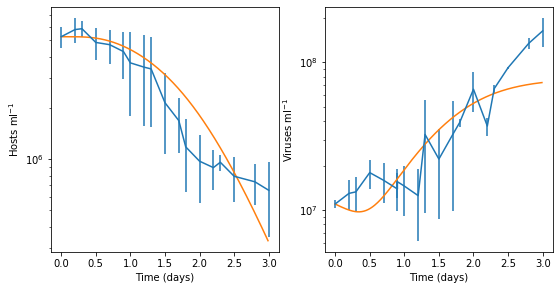

In [7]:
h,v = integrate(df,model_5infection,inits,times,pall.iloc[-1])
f,ax = pylab.subplots(1,2,figsize=[9,4.5])
ax[0].errorbar(df.loc['host']['time'],df.loc['host']['abundance'],yerr=df.loc['host']['uncertainty'])
ax[1].errorbar(df.loc['virus']['time'],df.loc['virus']['abundance'],yerr=df.loc['virus']['uncertainty'])
ax[0].plot(times,h,label='prior')
ax[1].plot(times,v)
ax[0].set_xlabel('Time (days)')
ax[1].set_xlabel('Time (days)')
ax[0].set_ylabel('Hosts ml$^{-1}$')
ax[1].set_ylabel('Viruses ml$^{-1}$')
ax[0].semilogy()
ax[1].semilogy()

# Alternate Plotting functions using R
One of the benefits of a jupyter notebook is the ability to swap between programing languages, namely python to R. In the following example, the pandas dataframe will be automatically converted to an R dataframe to be plotted with ggplot2. This way, you can use the clarity and tractibility of python and still have access to the vast libraries of R
I am about to push some changes to the modular branch. I 
In order for this to work, we will need to make a very big dataframe of all of our data

In [16]:
predh = pd.DataFrame({'time':times,'abundance':h,'organism':'mod-host'})
predv = pd.DataFrame({'time':times,'abundance':v,'organism':'mod-virus'})
#R is dumb and cannot do the indexing pandas can, so we resent the index
df_all = pd.concat([df.reset_index(),predh,predv])
df_all

,organism,time,abundance,uncertainty
0,virus,0.000000,1.098100e+07,656690.0
1,virus,0.200000,1.295900e+07,2987300.0
2,virus,0.300000,1.327300e+07,3480600.0
3,virus,0.500000,1.791400e+07,3981250.0
4,virus,0.700000,1.589900e+07,4815700.0
...,...,...,...,...
283,mod-virus,2.947917,7.246979e+07,NaN
284,mod-virus,2.958333,7.257160e+07,NaN
285,mod-virus,2.968750,7.267156e+07,NaN
286,mod-virus,2.979167,7.276970e+07,NaN


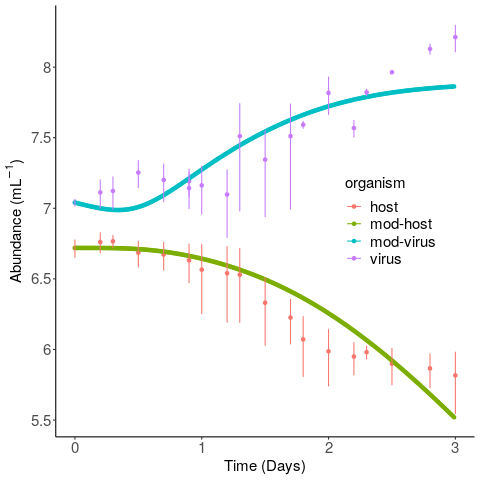

In [32]:
%%R -i df_all
library('ggplot2')

axis_text_size=15

plt <- ggplot(data=df_all,aes(x=time,y=abundance,color=organism))+
    geom_point()+
    geom_errorbar(aes(ymin=abundance-uncertainty, ymax=abundance+uncertainty))+
    scale_y_log10(
    breaks = scales::trans_breaks("log10", function(x) {10^x}),
    labels = scales::trans_format("log10", scales::math_format(.x)))+
    theme_bw()+
    labs(x="Time (Days)",y=bquote('Abundance ('*'mL'^-1*')'))+
    theme(panel.border = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.grid.major = element_blank(),
          axis.line = element_line(color="black"),
          legend.position = c(0.8,0.5),
          axis.text = element_text(size=axis_text_size),
          axis.title = element_text(size=axis_text_size),
          legend.title=element_text(size=axis_text_size),
          legend.text=element_text(size=axis_text_size))
print(plt)